Vectorized implemementation

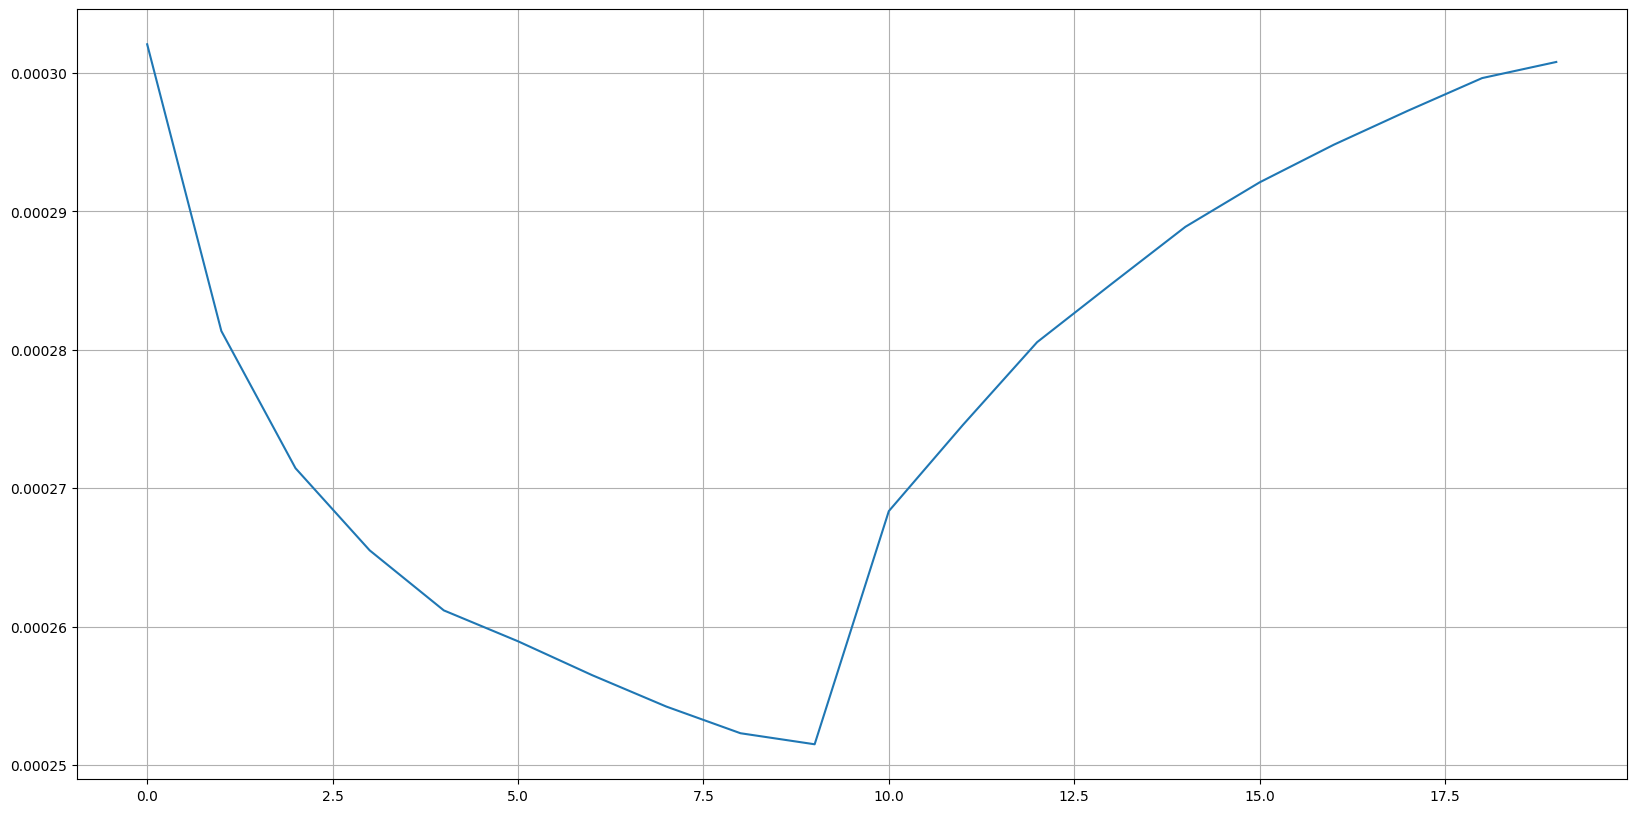

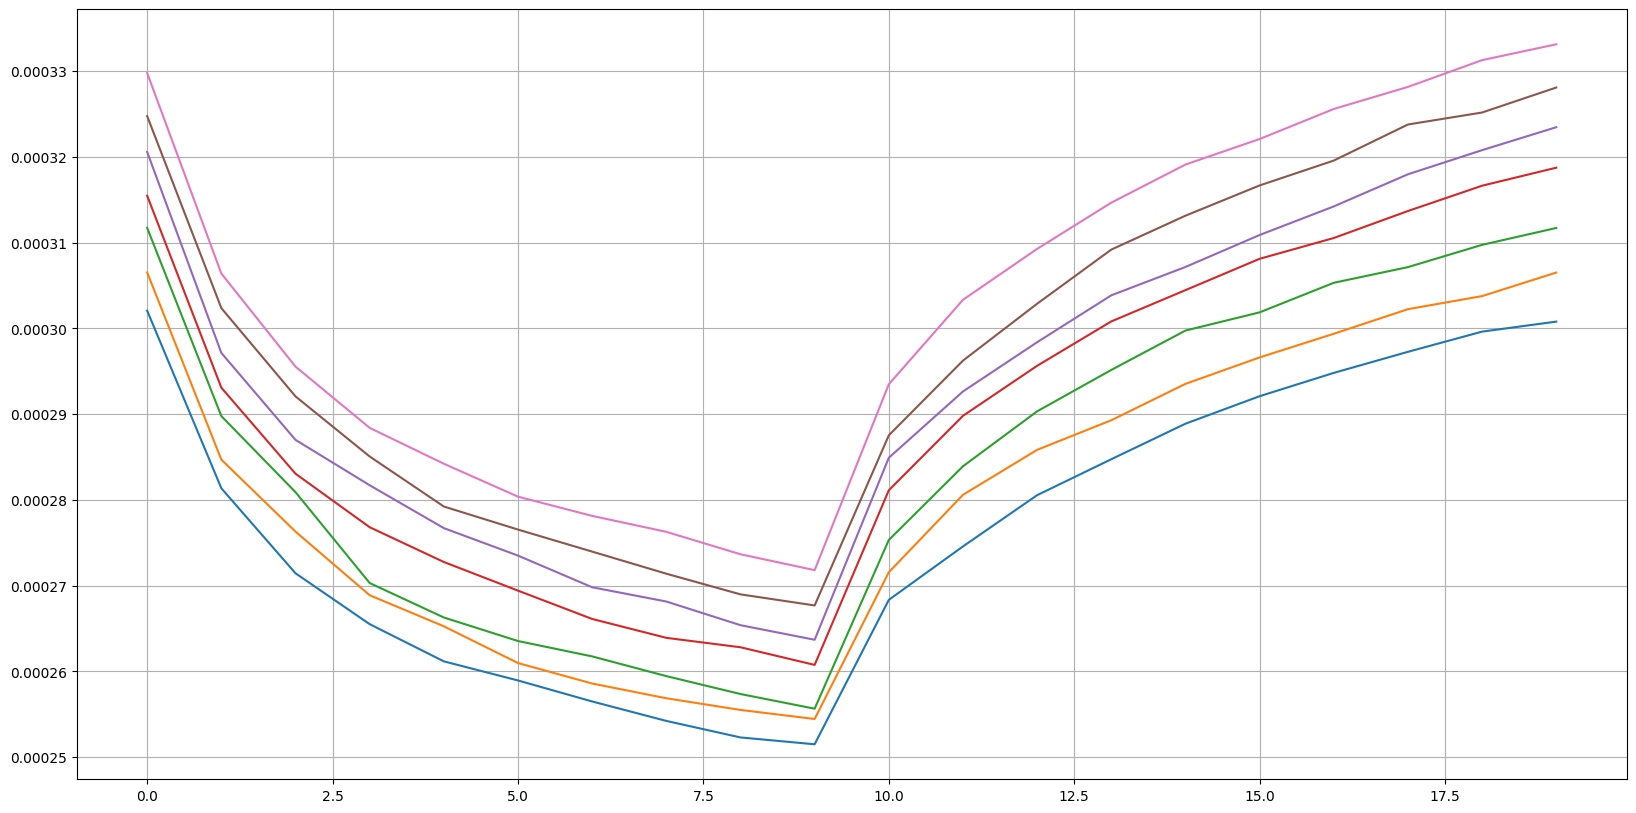

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import random
from torchvision import datasets, transforms

data1 = scipy.io.loadmat(r"JE1504_10u_r4c4_50_ohm_pot_dep_at_23-01-2024_17-39-54final_data_10.mat")
data2 = scipy.io.loadmat(r"JE1504_10u_r4c4_50_ohm_pot_dep_at_23-01-2024_17-46-44final_data_10.mat")
data3 = scipy.io.loadmat(r"JE1504_10u_r4c4_50_ohm_pot_dep_at_23-01-2024_17-53-02final_data_10.mat")
data1 = data1['combined_data']
data2 = data2['combined_data']
data3 = data3['combined_data']
# print the shape of the data

# reduce dimensionality of the data
data1 = np.squeeze(data1)
data2 = np.squeeze(data2)
data3 = np.squeeze(data3)

plt.figure(figsize=(20, 10))
plt.grid()
plt.plot(data1)
plt.show()

# lengths of data1 2 and 3 are multiples of 20. So we can reshape them to 20xN
data1 = data1.reshape(-1, 20)
data2 = data2.reshape(-1, 20)
data3 = data3.reshape(-1, 20)

# concatenate the data1, data2 and data3
data = np.concatenate((data1, data2, data3), axis=0)

# plot all rows of concatenated data
plt.figure(figsize=(20, 10))
plt.grid()
for i in range(data.shape[0]):
    plt.plot(data[i])
plt.show()

scaled_data = (data - 0.000256) / (0.000302 - 0.000256)
scaled_data = scaled_data


In [2]:
class Device_Idealized_Matrix:
    def __init__(self, num_rows, num_cols):
        self.noise = 0.1
        self.increment_scale_factor = 0.25
        self.decrement_scale_factor = 0.25
        self.device2device_variability_conductance_variation = 0
        self.cycle2cycle_variability_conductance_variation = 0.1
        self.average_max_conductance = 1
        self.average_min_conductance = -1
        self.device_weights = (self.average_max_conductance - self.average_min_conductance)*np.random.rand(num_rows, num_cols) + self.average_min_conductance

    def increment(self, increment_indexes):
        # increment_indexes contains the indexes of the devices to be incremented, 1 for increment, 0 for no change
        self.device_weights += increment_indexes*(self.average_max_conductance - self.device_weights) * self.increment_scale_factor * (1 + np.random.uniform(-self.noise, self.noise))

    def decrement(self, decrement_indexes):
        # decrement_indexes contains the indexes of the devices to be decremented, 1 for decrement, 0 for no change
        self.device_weights -= decrement_indexes*(self.device_weights - self.average_min_conductance)* self.decrement_scale_factor * (1 + np.random.uniform(-self.noise, self.noise))

    def read_weights(self):
        return self.device_weights
    
    def reset(self, reset_indexes):
        # reset_indexes, a matrix of num_rows and num_cols contains the indexes of the devices to be reset, 1 for reset, 0 for no change
        # create a numpy array of the same shape as device_weights
        self.device_weights_new = self.average_min_conductance + np.random.uniform(-self.cycle2cycle_variability_conductance_variation, self.cycle2cycle_variability_conductance_variation, self.device_weights.shape)
        self.device_weights = np.where(reset_indexes == 1, self.device_weights_new, self.device_weights)

    def set(self, set_indexes):
        # set_indexes, a matrix of num_rows and num_cols contains the indexes of the devices to be set, 1 for set, 0 for no change
        self.device_weights_new = self.average_max_conductance + np.random.uniform(-self.cycle2cycle_variability_conductance_variation, self.cycle2cycle_variability_conductance_variation, self.device_weights.shape)
        self.device_weights = np.where(set_indexes == 1, self.device_weights_new, self.device_weights)

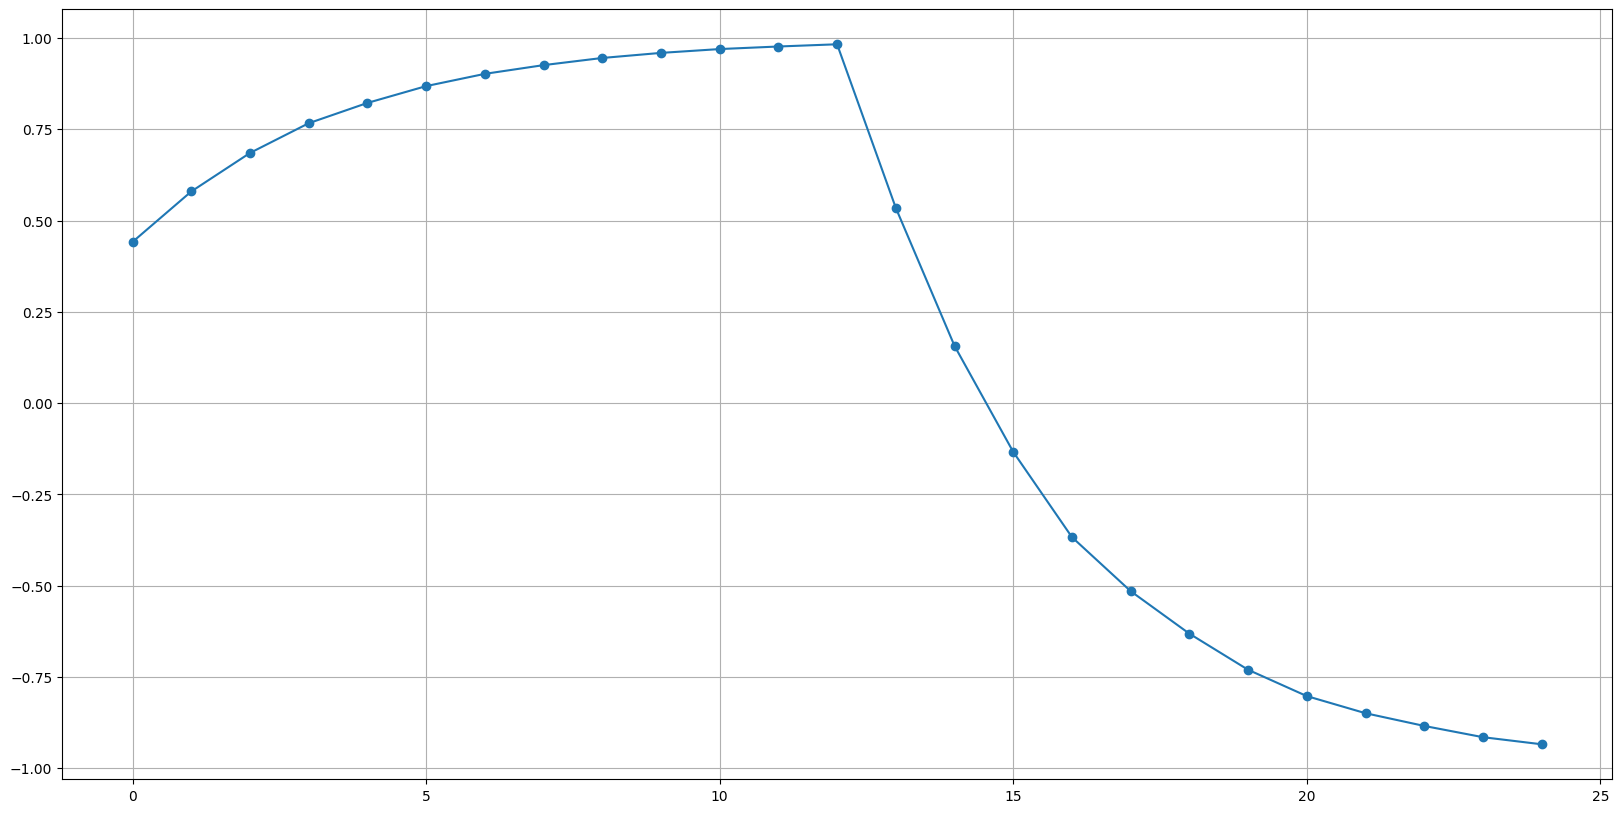

In [5]:
# simulate 12 incremental steps and 12 decremental steps
num_rows = 1
num_cols = 1
device = Device_Idealized_Matrix(num_rows, num_cols)   

weight_list = []
weight_list.append(device.read_weights()[0][0])
for i in range(12):
    increment_indexes = np.asarray([[1]])
    device.increment(increment_indexes)
    weight_list.append(device.read_weights()[0][0])

for i in range(12):
    decrement_indexes = np.asarray([[1]])
    device.decrement(decrement_indexes)
    weight_list.append(device.read_weights()[0][0])

plt.figure(figsize=(20, 10))
plt.grid()
plt.plot(weight_list, marker='o')
plt.show()

In [6]:
class Composite_Device_Idealized_Matrix:
    def __init__(self, num_rows, num_cols, scaling_weights):
        # sort scaling weights in ascending order
        scaling_weights = np.sort(scaling_weights)
        self.scaling_weights = scaling_weights
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.len_scaling_weights = len(scaling_weights)
        self.device_arrays = [Device_Idealized_Matrix(num_rows, num_cols) for i in range(self.len_scaling_weights)]
        self.cutoff_zone_d = 0.80
        self.cutoff_zone_p = -0.80

        # total weight = weighted sum of all the device_weight arrays
        self.total_weight = np.zeros((num_rows, num_cols), dtype=np.float32)

        for i in range(self.len_scaling_weights):
            self.total_weight += self.scaling_weights[i]*self.device_arrays[i].read_weights()

    def increment(self, increment_indexes):
        
        # layer_1_indices = np.where(self.device_arrays[0].read_weights() < self.cutoff_zone_d)
        # self.device_arrays[0].increment(increment_indexes=layer_1_indices)

        and_array = np.ones((self.num_rows, self.num_cols), dtype=bool)

        # AND between and array and increment indexes
        and_array = np.logical_and(and_array, increment_indexes)        
        
        or_array = np.zeros((self.num_rows, self.num_cols), dtype=bool)
        reset_list = []
        # # change datatype of and array to boolean
        # and_array = and_array.astype(bool)
        
        for i in range(self.len_scaling_weights):
            # print("Device array: ", i)
            out_of_zone_d_indices = self.device_arrays[i].read_weights() > self.cutoff_zone_d
            # print("Out of zone d indices: ", out_of_zone_d_indices)

            # increment indexes = XOR between and_array and out_of_zone_d_indices
            increment_indexes = np.logical_xor(and_array, out_of_zone_d_indices)
            # print("Increment indexes: ", increment_indexes)

            # make increment_indexes 0 where or_array is 1
            increment_indexes = np.where(or_array == 1, 0, increment_indexes)
            # print("Increment indexes after or_array: ", increment_indexes)

            # increment the devices
            self.device_arrays[i].increment(increment_indexes)


            # OR between or_array and increment_indexes
            or_array = np.logical_or(or_array, increment_indexes)
            # print("Or array: ", or_array)

            # AND between and_array and out_of_zone_d_indices
            and_array = np.logical_and(and_array, out_of_zone_d_indices)
            # print("And array: ", and_array)

            reset_list.append(and_array)

        for i in range(self.len_scaling_weights - 1):
            reset_indices = np.where(reset_list[-1] == 1, 0, reset_list[i])
            self.device_arrays[i].reset(reset_indices)

    def decrement(self, decrement_indexes):
            
            and_array = np.ones((self.num_rows, self.num_cols), dtype=bool)
            or_array = np.zeros((self.num_rows, self.num_cols), dtype=bool)

            # AND between and array and decrement indexes
            and_array = np.logical_and(and_array, decrement_indexes)
            # # change datatype of and array to boolean
            # and_array = and_array.astype(bool)
            set_list = []

            for i in range(self.len_scaling_weights):
                out_of_zone_p_indices = self.device_arrays[i].read_weights() < self.cutoff_zone_p
    
                # decrement indexes = XOR between and_array and out_of_zone_d_indices
                decrement_indexes = np.logical_xor(and_array, out_of_zone_p_indices)
    
                # make decrement_indexes 0 where or_array is 1
                decrement_indexes = np.where(or_array == 1, 0, decrement_indexes)
    
                # decrement the devices
                self.device_arrays[i].decrement(decrement_indexes)
    
                # OR between or_array and decrement_indexes
                or_array = np.logical_or(or_array, decrement_indexes)
    
                # AND between and_array and out_of_zone_d_indices
                and_array = np.logical_and(and_array, out_of_zone_p_indices)

                set_list.append(and_array)

            for i in range(self.len_scaling_weights - 1):
                set_indices = np.where(set_list[-1] == 1, 0, set_list[i])
                self.device_arrays[i].set(set_indices)

    def read_weights(self):
        self.total_weight = np.zeros((self.num_rows, self.num_cols), dtype=np.float32)
        for i in range(self.len_scaling_weights):
            self.total_weight += self.scaling_weights[i]*self.device_arrays[i].read_weights()
        return self.total_weight
    




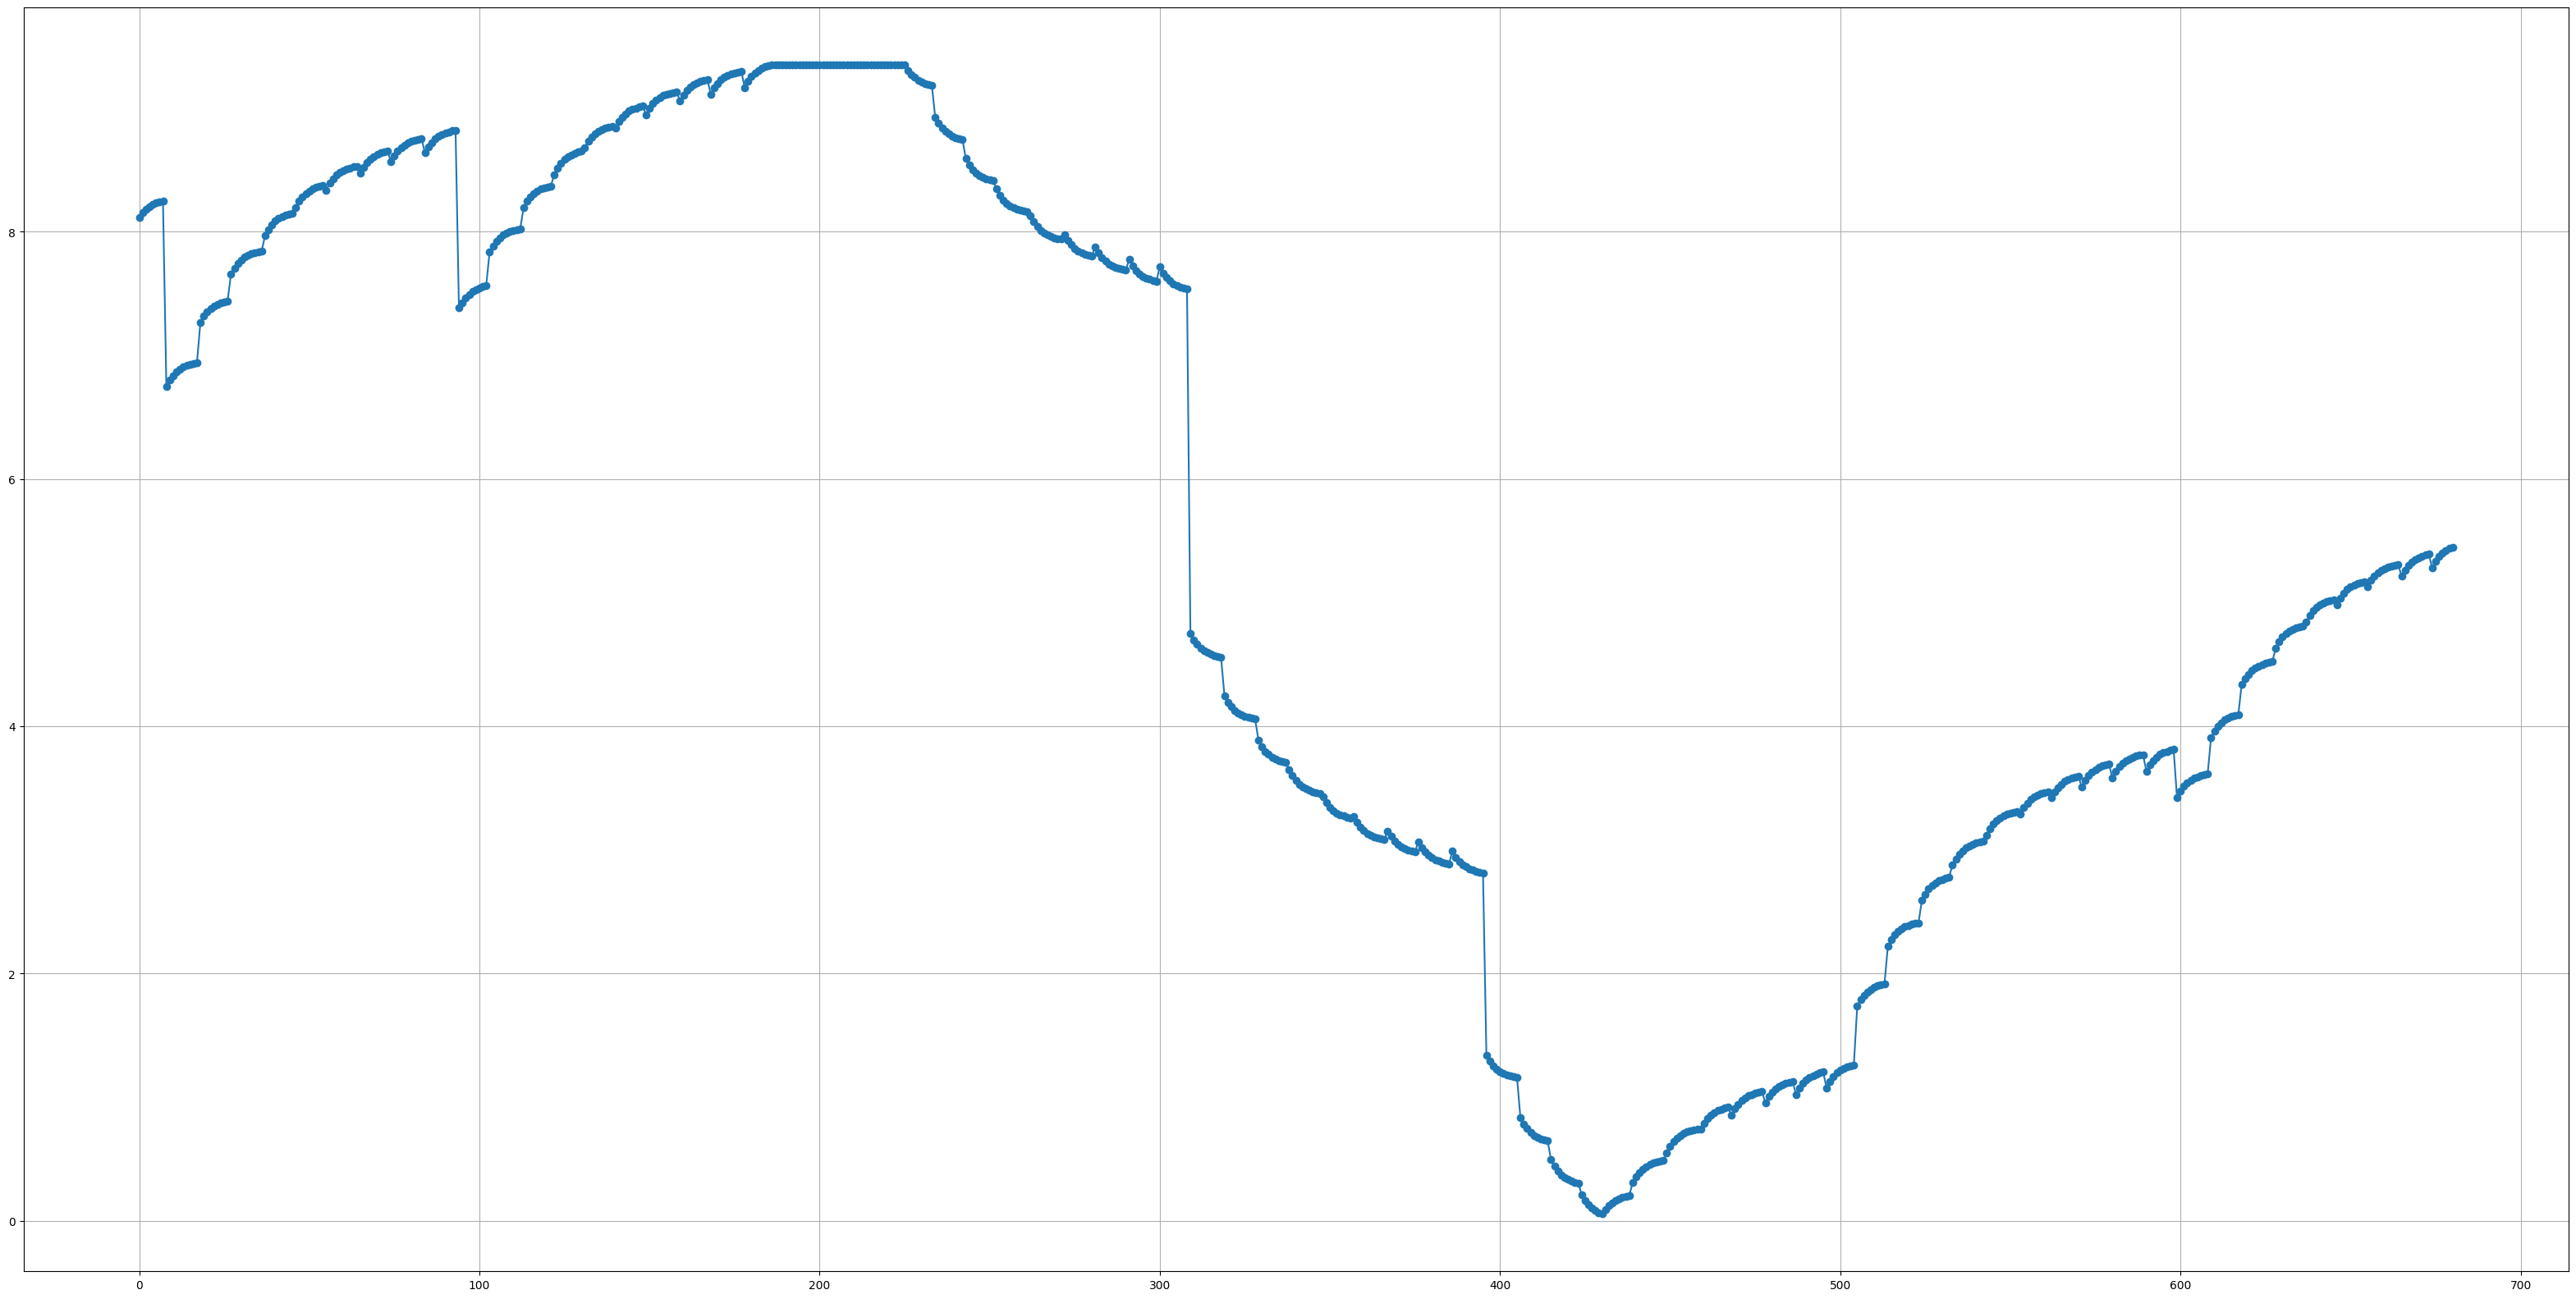

In [11]:
# Simulate a neuron by num_rows = 1, num_columns = 1

# create a composite device with 1 row and 1 column
composite_device = Composite_Device_Idealized_Matrix(num_rows=1, num_cols=1, scaling_weights=[0.1,1,10])

# read the weights of the composite device
# print(composite_device.read_weights()[0][0])

weight_list = []

weight_list.append(composite_device.read_weights()[0][0])

increment_indexes = np.ones((1,1))

# increment the weights of the composite device
for i in range(225):
    # print("Increment ", i)
    composite_device.increment(increment_indexes=increment_indexes)
    weight_list.append(composite_device.read_weights()[0][0])


# decrement the weights of the composite device
for i in range(205):
    composite_device.decrement(decrement_indexes=increment_indexes)
    weight_list.append(composite_device.read_weights()[0][0])


for i in range(250):
    # print("Increment ", i)
    composite_device.increment(increment_indexes=increment_indexes)
    weight_list.append(composite_device.read_weights()[0][0])

plt.figure(figsize=(40, 20))
plt.grid()
plt.plot(weight_list, marker='o')
plt.show()

    


In [14]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(784, 250, bias = False)
        self.fc2 = nn.Linear(250, 10, bias = False)

    def forward(self, x):
        x1 = F.sigmoid(self.fc1(x))
        x2 = self.fc2(x1)
        return x2

# Initialize the model
model = MyModel()
# Define the loss function
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.MSELoss()
# loss_fn = nn.MSELoss

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1)
print(model)

MyModel(
  (fc1): Linear(in_features=784, out_features=250, bias=False)
  (fc2): Linear(in_features=250, out_features=10, bias=False)
)


In [15]:
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# transform = transforms.Compose([transforms.ToTensor()])

import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms

# Define the transformation to convert data to tensors
transform = transforms.ToTensor()

# Load the MNIST dataset
full_train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
full_test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=transform)


train_loader = DataLoader(full_train_dataset, batch_size=64)

test_loader = DataLoader(full_test_dataset, batch_size=64)

In [29]:
layer_wise_composite_device_array = []
# each layer can be represented by one matrix of appropriate rows and columns

# Calculate number of layers in our model
num_layers = 2

input_sizes = [784, 250]
output_sizes = [250, 10]

for i in range(num_layers):
    layer_wise_composite_device_array.append(Composite_Device_Idealized_Matrix(num_rows=output_sizes[i], num_cols=input_sizes[i], scaling_weights=[0.01,0.1,1]))


In [30]:
# First, assign the corresponding device weight to the model
# Calculate the new weights
new_weights_1 = layer_wise_composite_device_array[0].read_weights()
new_weights_2 = layer_wise_composite_device_array[1].read_weights()

buffer = new_weights_1*1

# Assign the new weights to the model
model.fc1.weight.data = torch.from_numpy(new_weights_1)
model.fc2.weight.data = torch.from_numpy(new_weights_2)

num_epochs = 1
num_steps_per_batch = 1

weight_evolution_list_1 = []
weight_evolution_list_2 = []
weight_evolution_list_3 = []
weight_evolution_list_4 = []
weight_evolution_list_5 = []
# The training loop

for epoch in range(1):  
    batch_number = 0
    for batch, (images, labels) in enumerate(train_loader):
        batch_number += 1
        for step in range(num_steps_per_batch):
            images2 = images.view(images.shape[0], -1)
            # print(images.shape)
            # Forward pass
            output = model(images2)
            # print(output.shape)
            # Calculate the loss
            loss = loss_fn(output, labels)
            # print(output)
            # print(labels)
            # print(loss)
            # Zero the gradients
            optimizer.zero_grad()
            # Backward pass
            loss.backward()

            # Extract weights in numpy 2d arrays
            weights_1 = model.fc1.weight.data.numpy()
            weights_2 = model.fc2.weight.data.numpy()

            # Extract the gradients in numpy 2d arrays
            grad_1 = model.fc1.weight.grad.numpy()
            grad_2 = model.fc2.weight.grad.numpy()

            # For layer 1
            layer_wise_composite_device_array[0].increment(increment_indexes = (grad_1 < 0))
            layer_wise_composite_device_array[0].decrement(decrement_indexes = (grad_1 > 0))

            # For layer 2
            layer_wise_composite_device_array[1].increment(increment_indexes = (grad_2 < 0))
            layer_wise_composite_device_array[1].decrement(decrement_indexes = (grad_2 > 0))

            # Calculate the new weights
            new_weights_1 = layer_wise_composite_device_array[0].read_weights()
            new_weights_2 = layer_wise_composite_device_array[1].read_weights()

            weight_evolution_list_1.append(new_weights_1[0][0])
            weight_evolution_list_2.append(new_weights_1[20][100])
            weight_evolution_list_3.append(new_weights_1[7][7])
            weight_evolution_list_4.append(new_weights_2[0][0])
            weight_evolution_list_5.append(new_weights_2[2][10])

            # Assign the new weights to the model
            model.fc1.weight.data = torch.from_numpy(new_weights_1)
            model.fc2.weight.data = torch.from_numpy(new_weights_2)

        # Print the loss
        print('Batch Number {}, Loss: {:.4f}'.format(batch_number, loss.item()))


Batch Number 1, Loss: 8.1510
Batch Number 2, Loss: 8.3202
Batch Number 3, Loss: 6.8573
Batch Number 4, Loss: 8.1158
Batch Number 5, Loss: 6.4212
Batch Number 6, Loss: 5.2656
Batch Number 7, Loss: 6.3135
Batch Number 8, Loss: 5.4665
Batch Number 9, Loss: 5.8938
Batch Number 10, Loss: 4.5544
Batch Number 11, Loss: 3.2109
Batch Number 12, Loss: 4.0994
Batch Number 13, Loss: 3.9325
Batch Number 14, Loss: 2.3096
Batch Number 15, Loss: 3.0589
Batch Number 16, Loss: 2.5160
Batch Number 17, Loss: 3.0900
Batch Number 18, Loss: 2.8814
Batch Number 19, Loss: 2.3340
Batch Number 20, Loss: 2.6249
Batch Number 21, Loss: 2.3370
Batch Number 22, Loss: 2.7359
Batch Number 23, Loss: 2.4827
Batch Number 24, Loss: 1.9719
Batch Number 25, Loss: 1.9473
Batch Number 26, Loss: 1.9994
Batch Number 27, Loss: 1.2261
Batch Number 28, Loss: 1.3173
Batch Number 29, Loss: 2.2497
Batch Number 30, Loss: 1.5514
Batch Number 31, Loss: 1.7953
Batch Number 32, Loss: 1.9778
Batch Number 33, Loss: 1.5147
Batch Number 34, Lo

In [31]:
# The testing loop

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.shape[0], -1)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: {:.2f}%'.format(100 * correct / total))



Accuracy: 87.51%


In [32]:
print(" Predicted  ",predicted)
print("True Labels ", labels)
print(outputs)

 Predicted   tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 8, 6])
True Labels  tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6])
tensor([[-9.7253e+00,  9.9452e+00, -1.3428e+00,  2.7960e+00, -5.7789e+00,
         -4.9559e+00, -4.6565e+00,  4.8664e-01, -5.6755e-01,  1.2097e-01],
        [-4.8520e+00, -2.8077e-01,  5.6698e+00,  4.0002e+00, -2.5756e+00,
         -1.2892e+00, -5.3932e+00,  4.5286e+00,  2.3867e+00, -2.6699e-01],
        [-8.1134e-01, -1.9824e+00,  2.2718e+00,  7.4520e+00, -4.7282e+00,
          3.4398e-01, -6.3074e+00,  1.0816e+00,  6.7035e+00,  2.1283e+00],
        [-2.7906e+00, -5.9283e+00, -2.9507e+00,  7.0830e-02,  1.2541e+01,
          2.6101e+00,  1.4633e+00,  4.6471e-01,  4.7239e+00,  5.6024e+00],
        [ 3.4990e+00, -9.5728e+00, -3.8826e+00,  5.5710e+00, -7.9618e-01,
          1.1454e+01, -4.8351e+00, -1.4412e+00,  4.4181e+00,  6.7234e-01],
        [ 3.5637e+00, -6.6509e+00,  4.5518e+00,  6.6993e-02,  1.1921e+00,
         -9.6874e-01,  1.3376e+01, -4.333

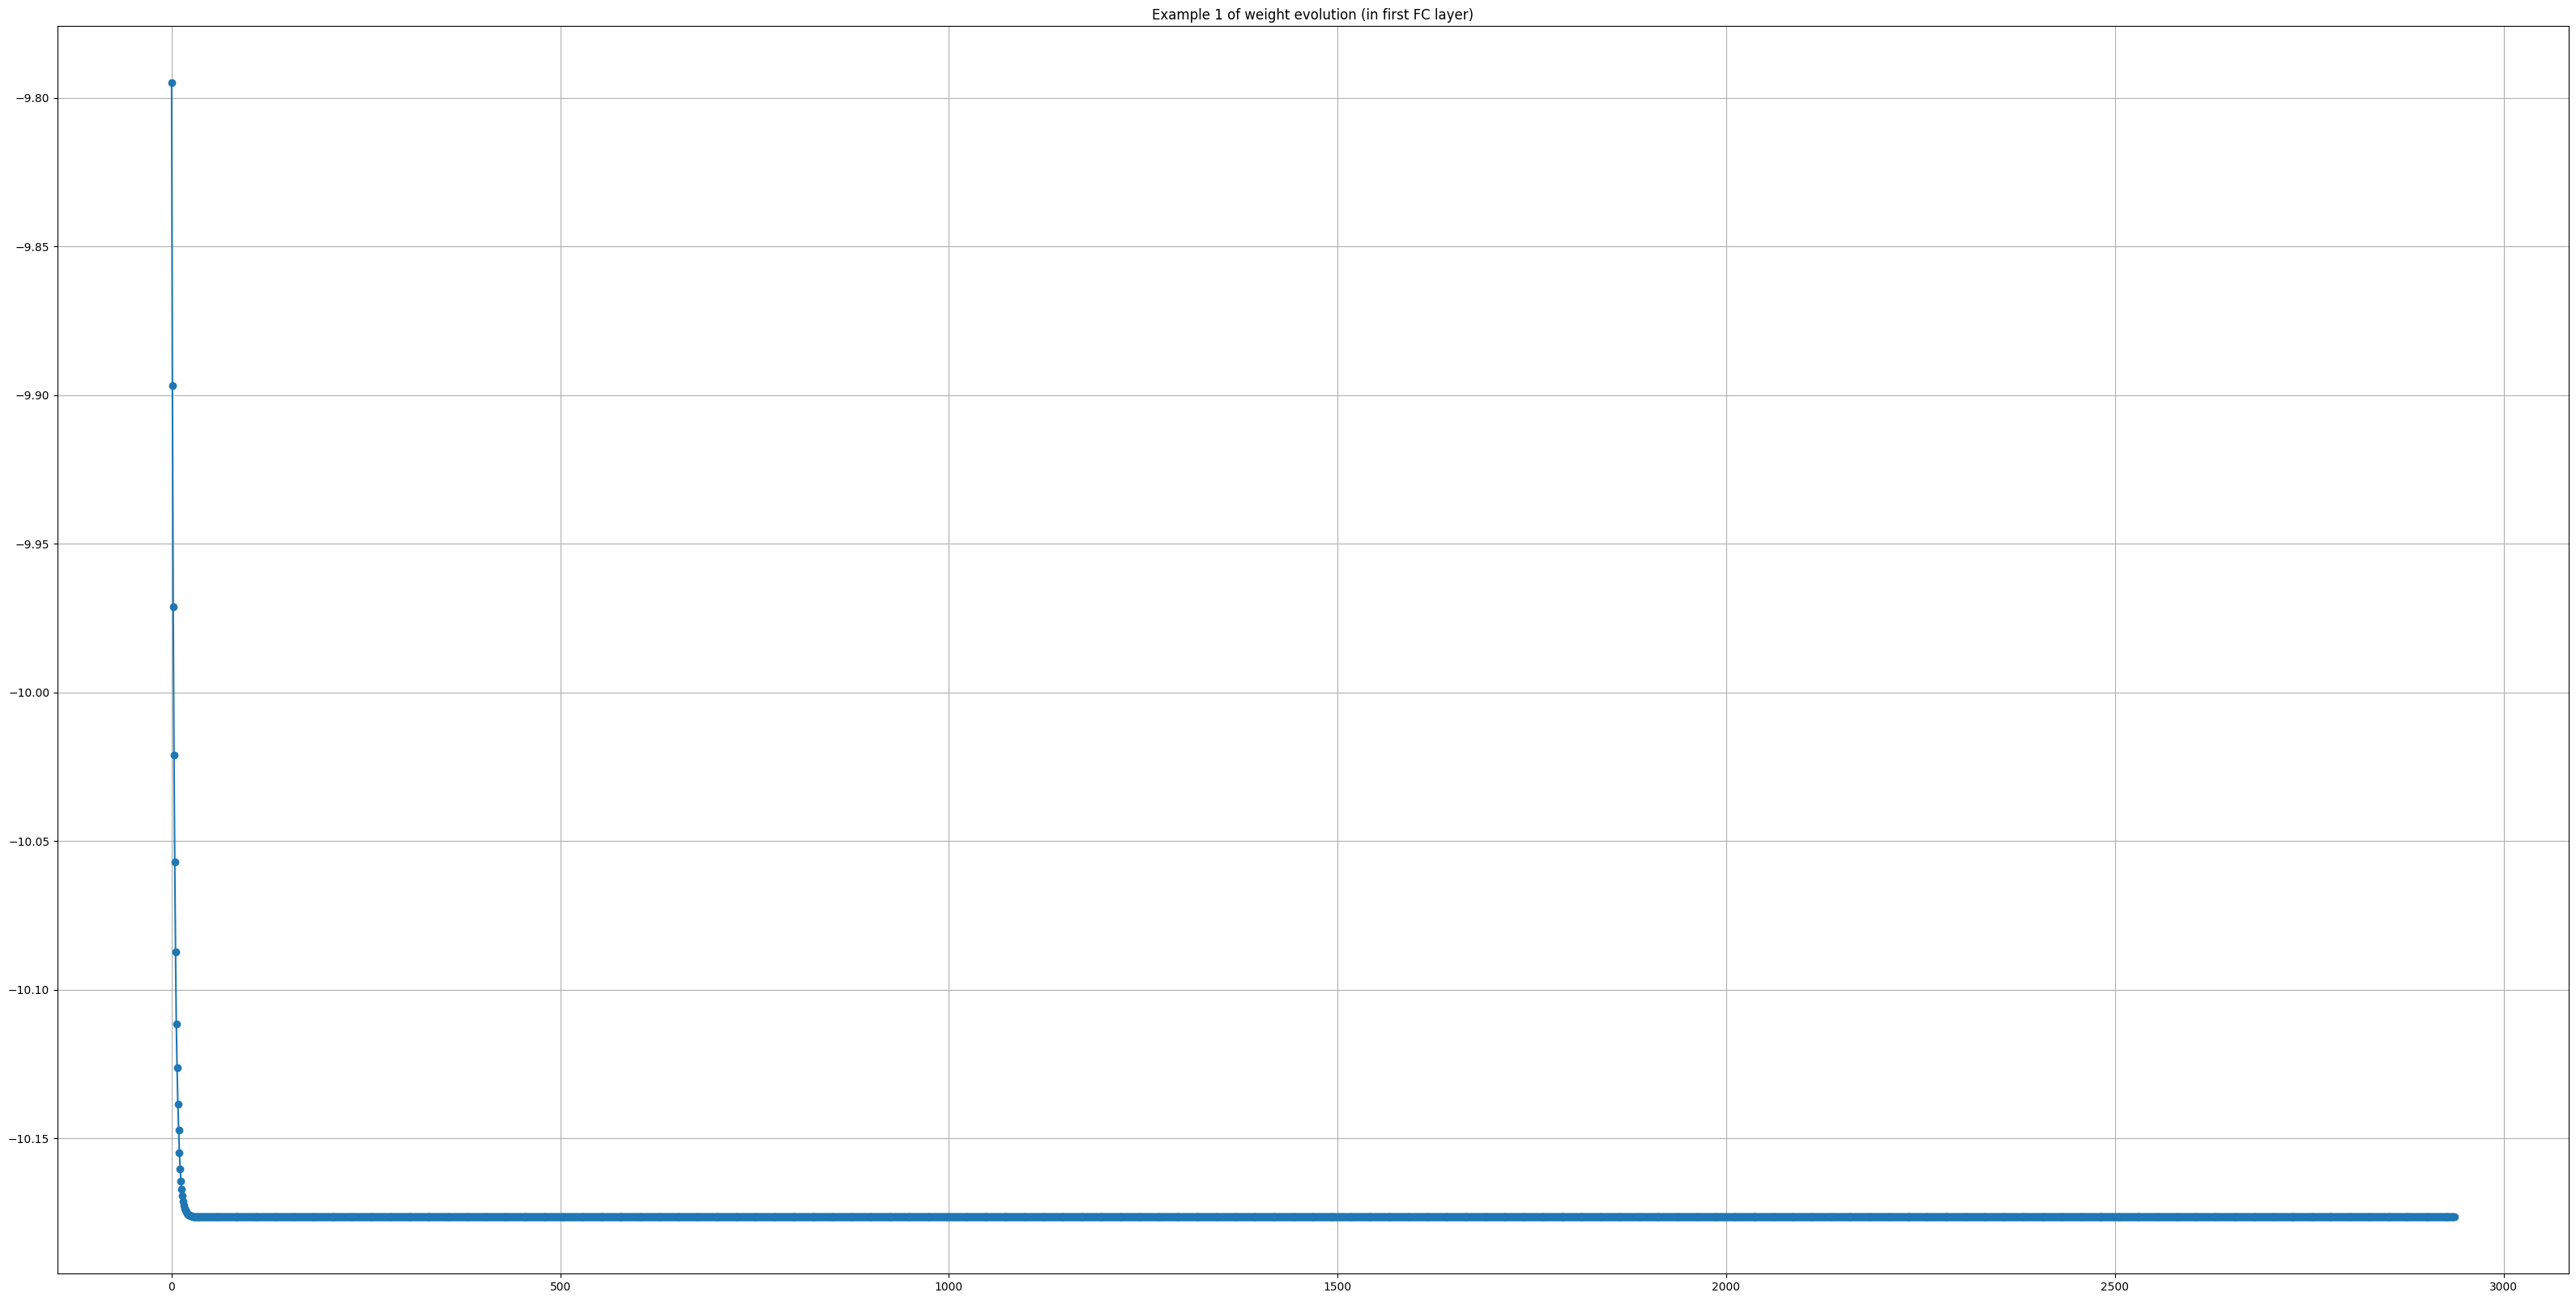

In [349]:
# Plot some weight evolution
plt.figure(figsize=(40, 20))
plt.grid()
plt.title("Example 1 of weight evolution (in first FC layer)")
plt.plot(weight_evolution_list_1, marker='o')
plt.show()


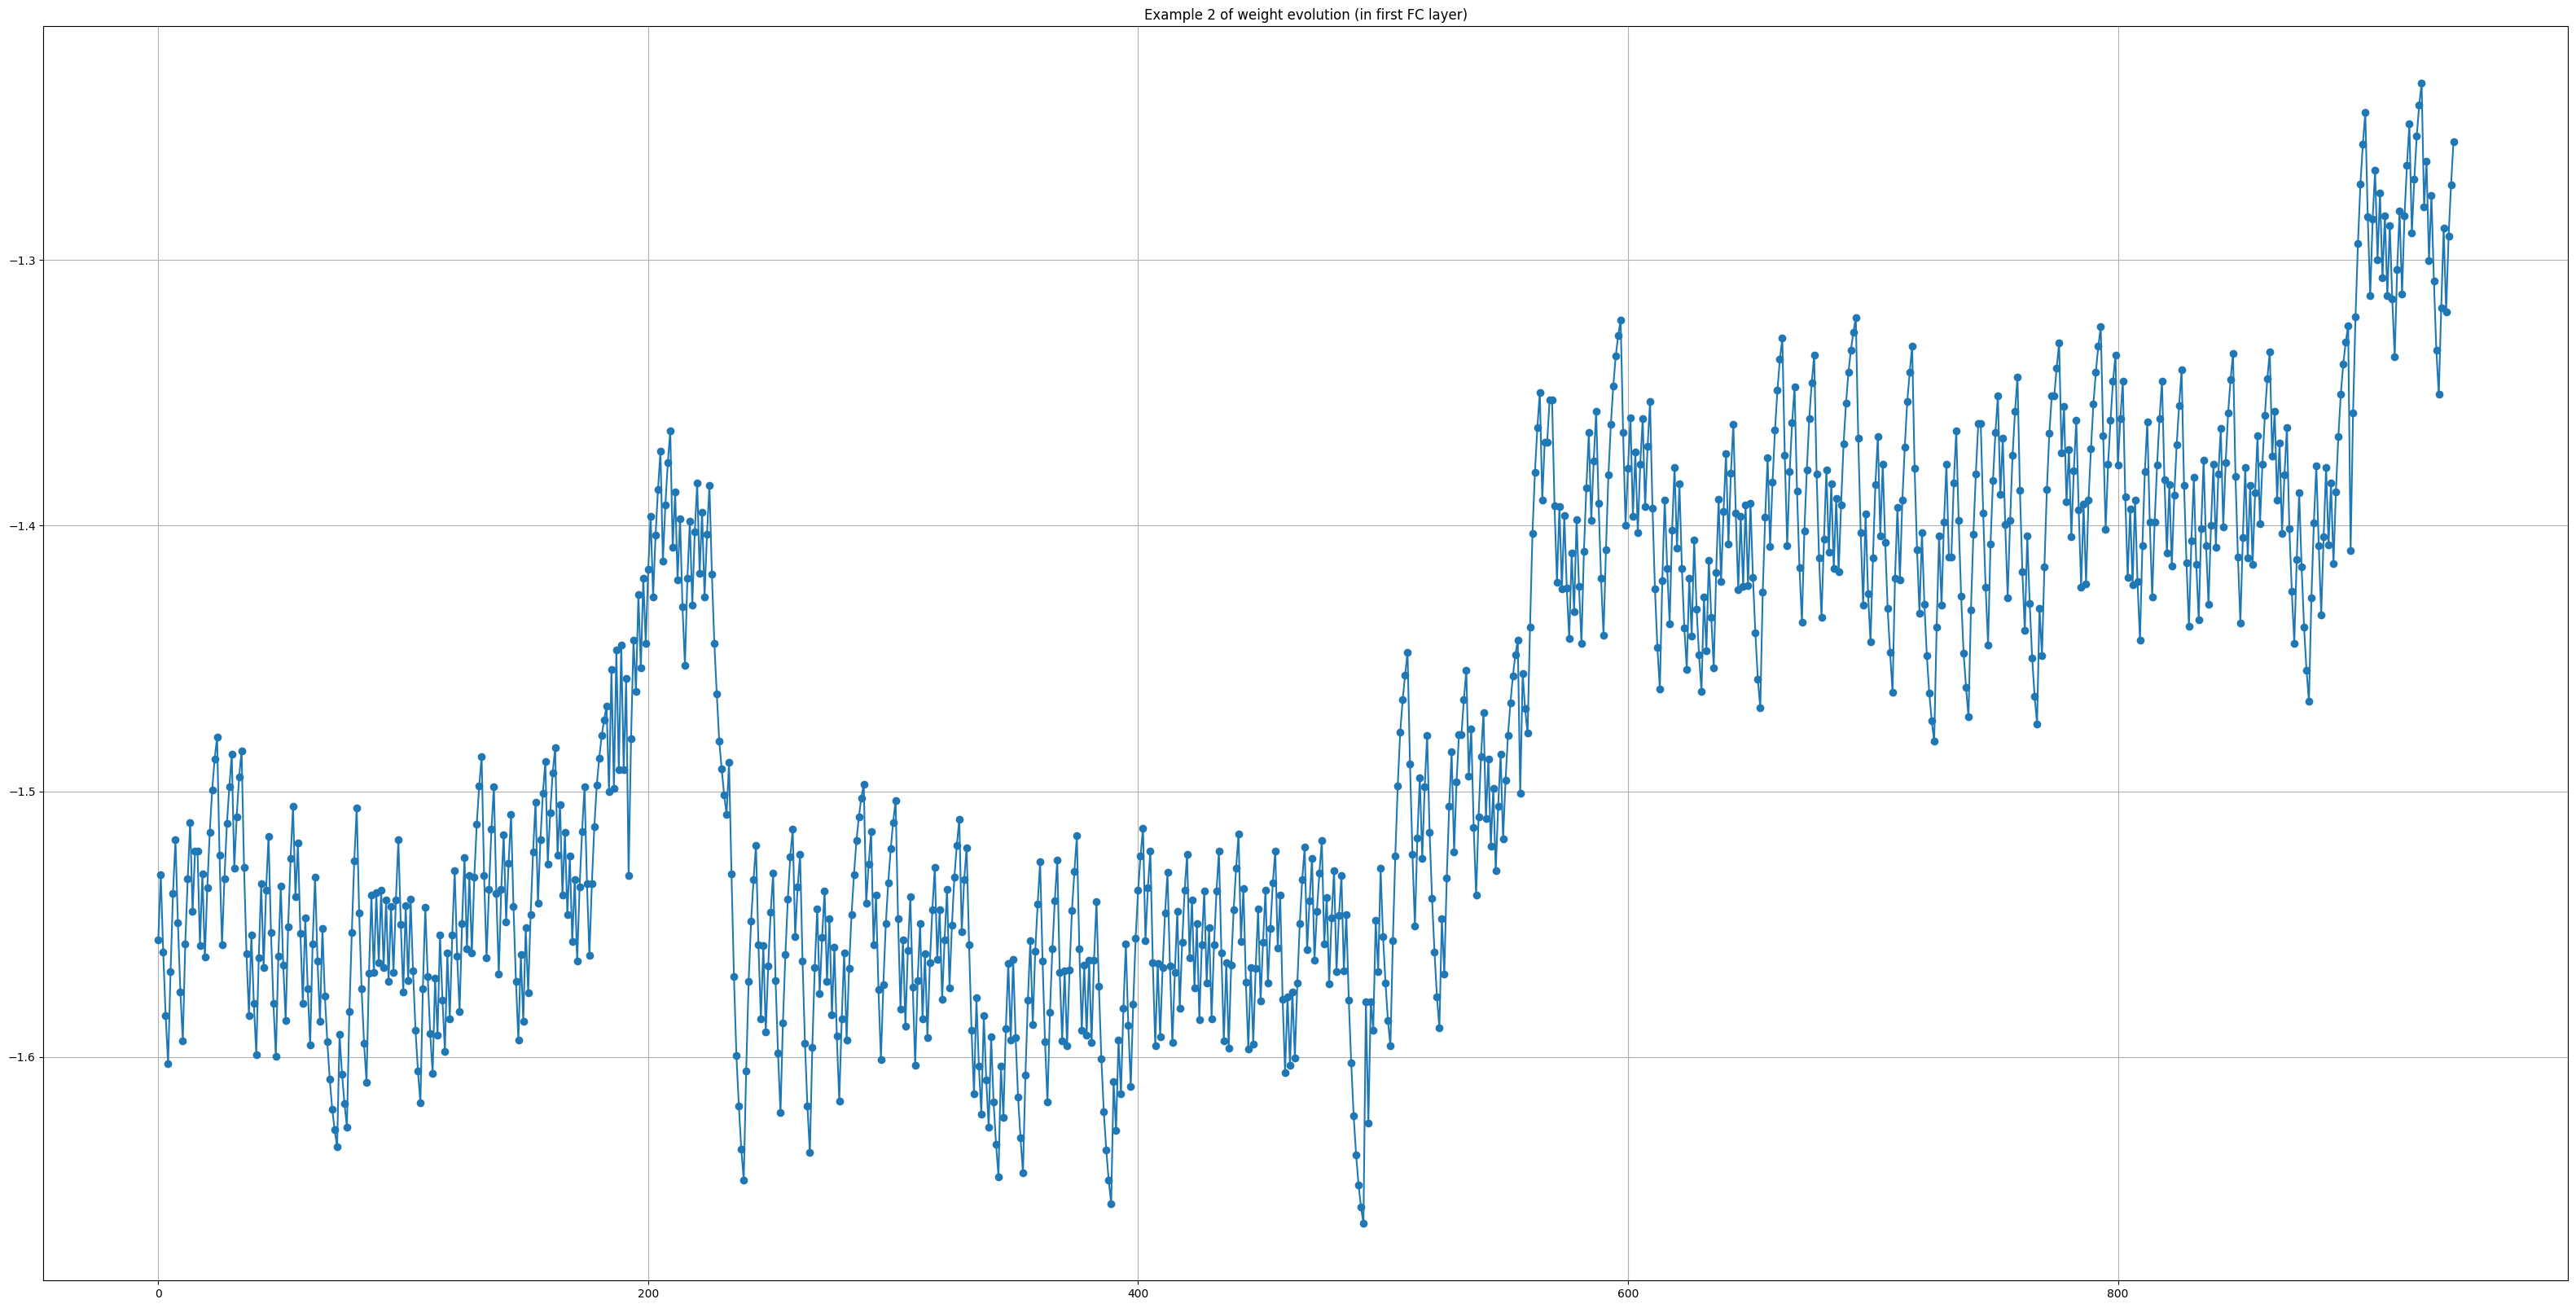

In [26]:
plt.figure(figsize=(40, 20))
plt.grid()
plt.title("Example 2 of weight evolution (in first FC layer)")
plt.plot(weight_evolution_list_2, marker='o')
plt.show()


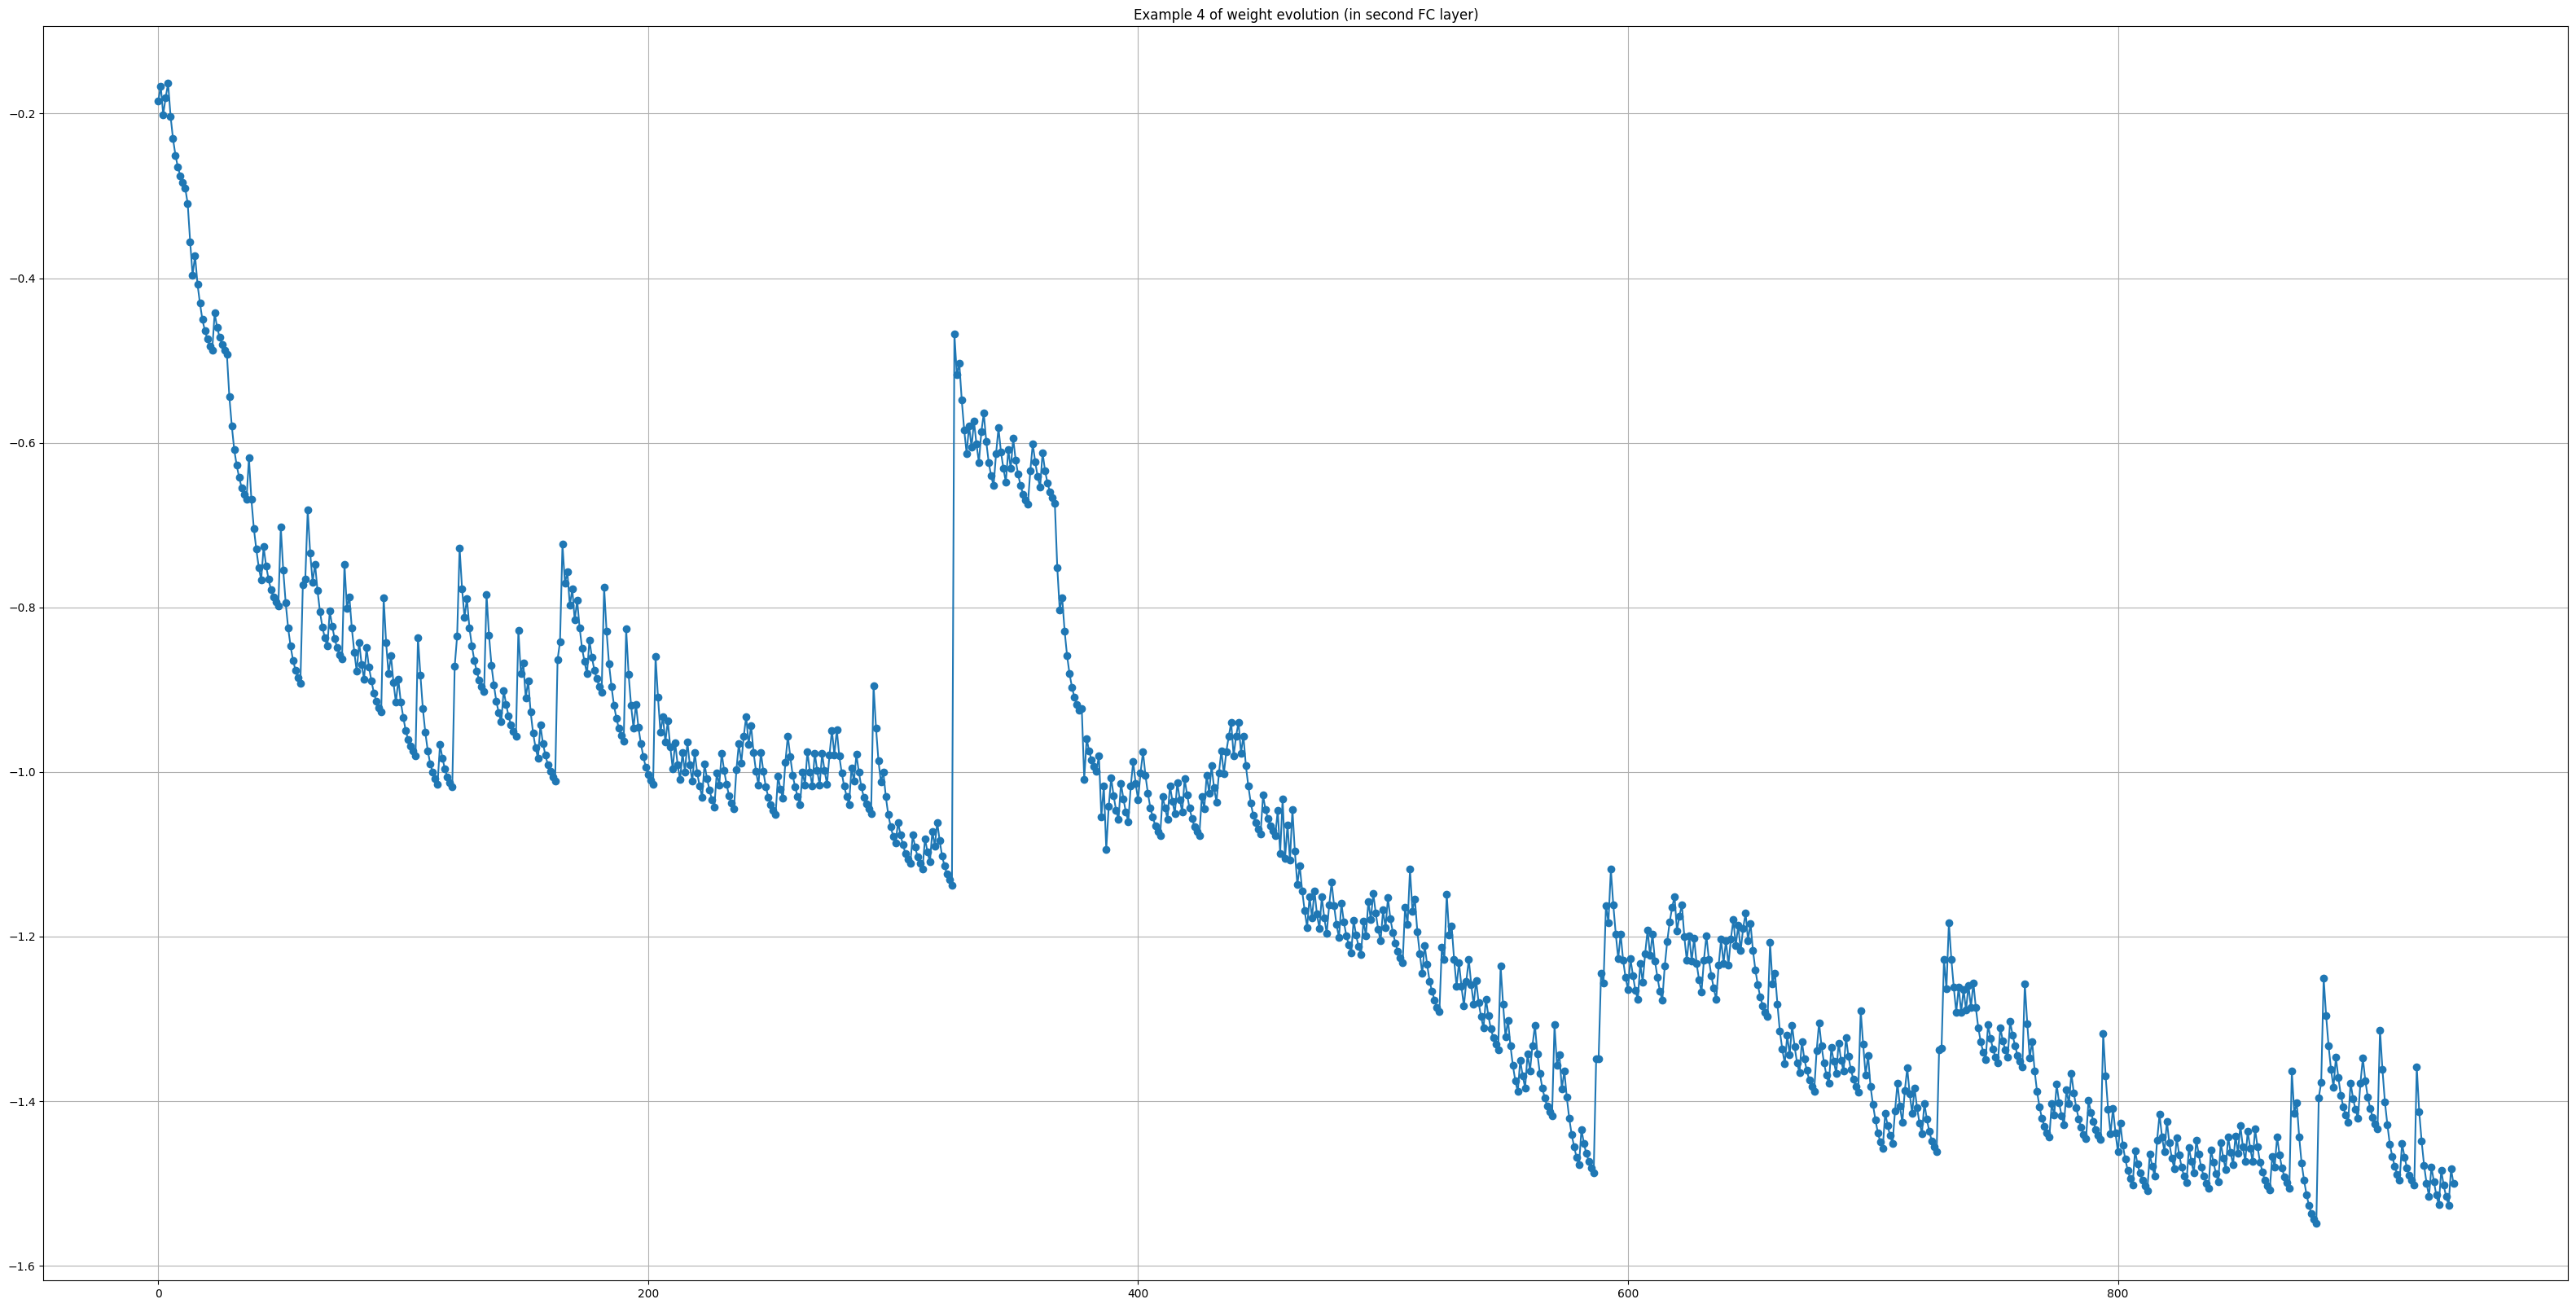

In [27]:
plt.figure(figsize=(40, 20))
plt.grid()
plt.title("Example 4 of weight evolution (in second FC layer)")
plt.plot(weight_evolution_list_4, marker='o')
plt.show()

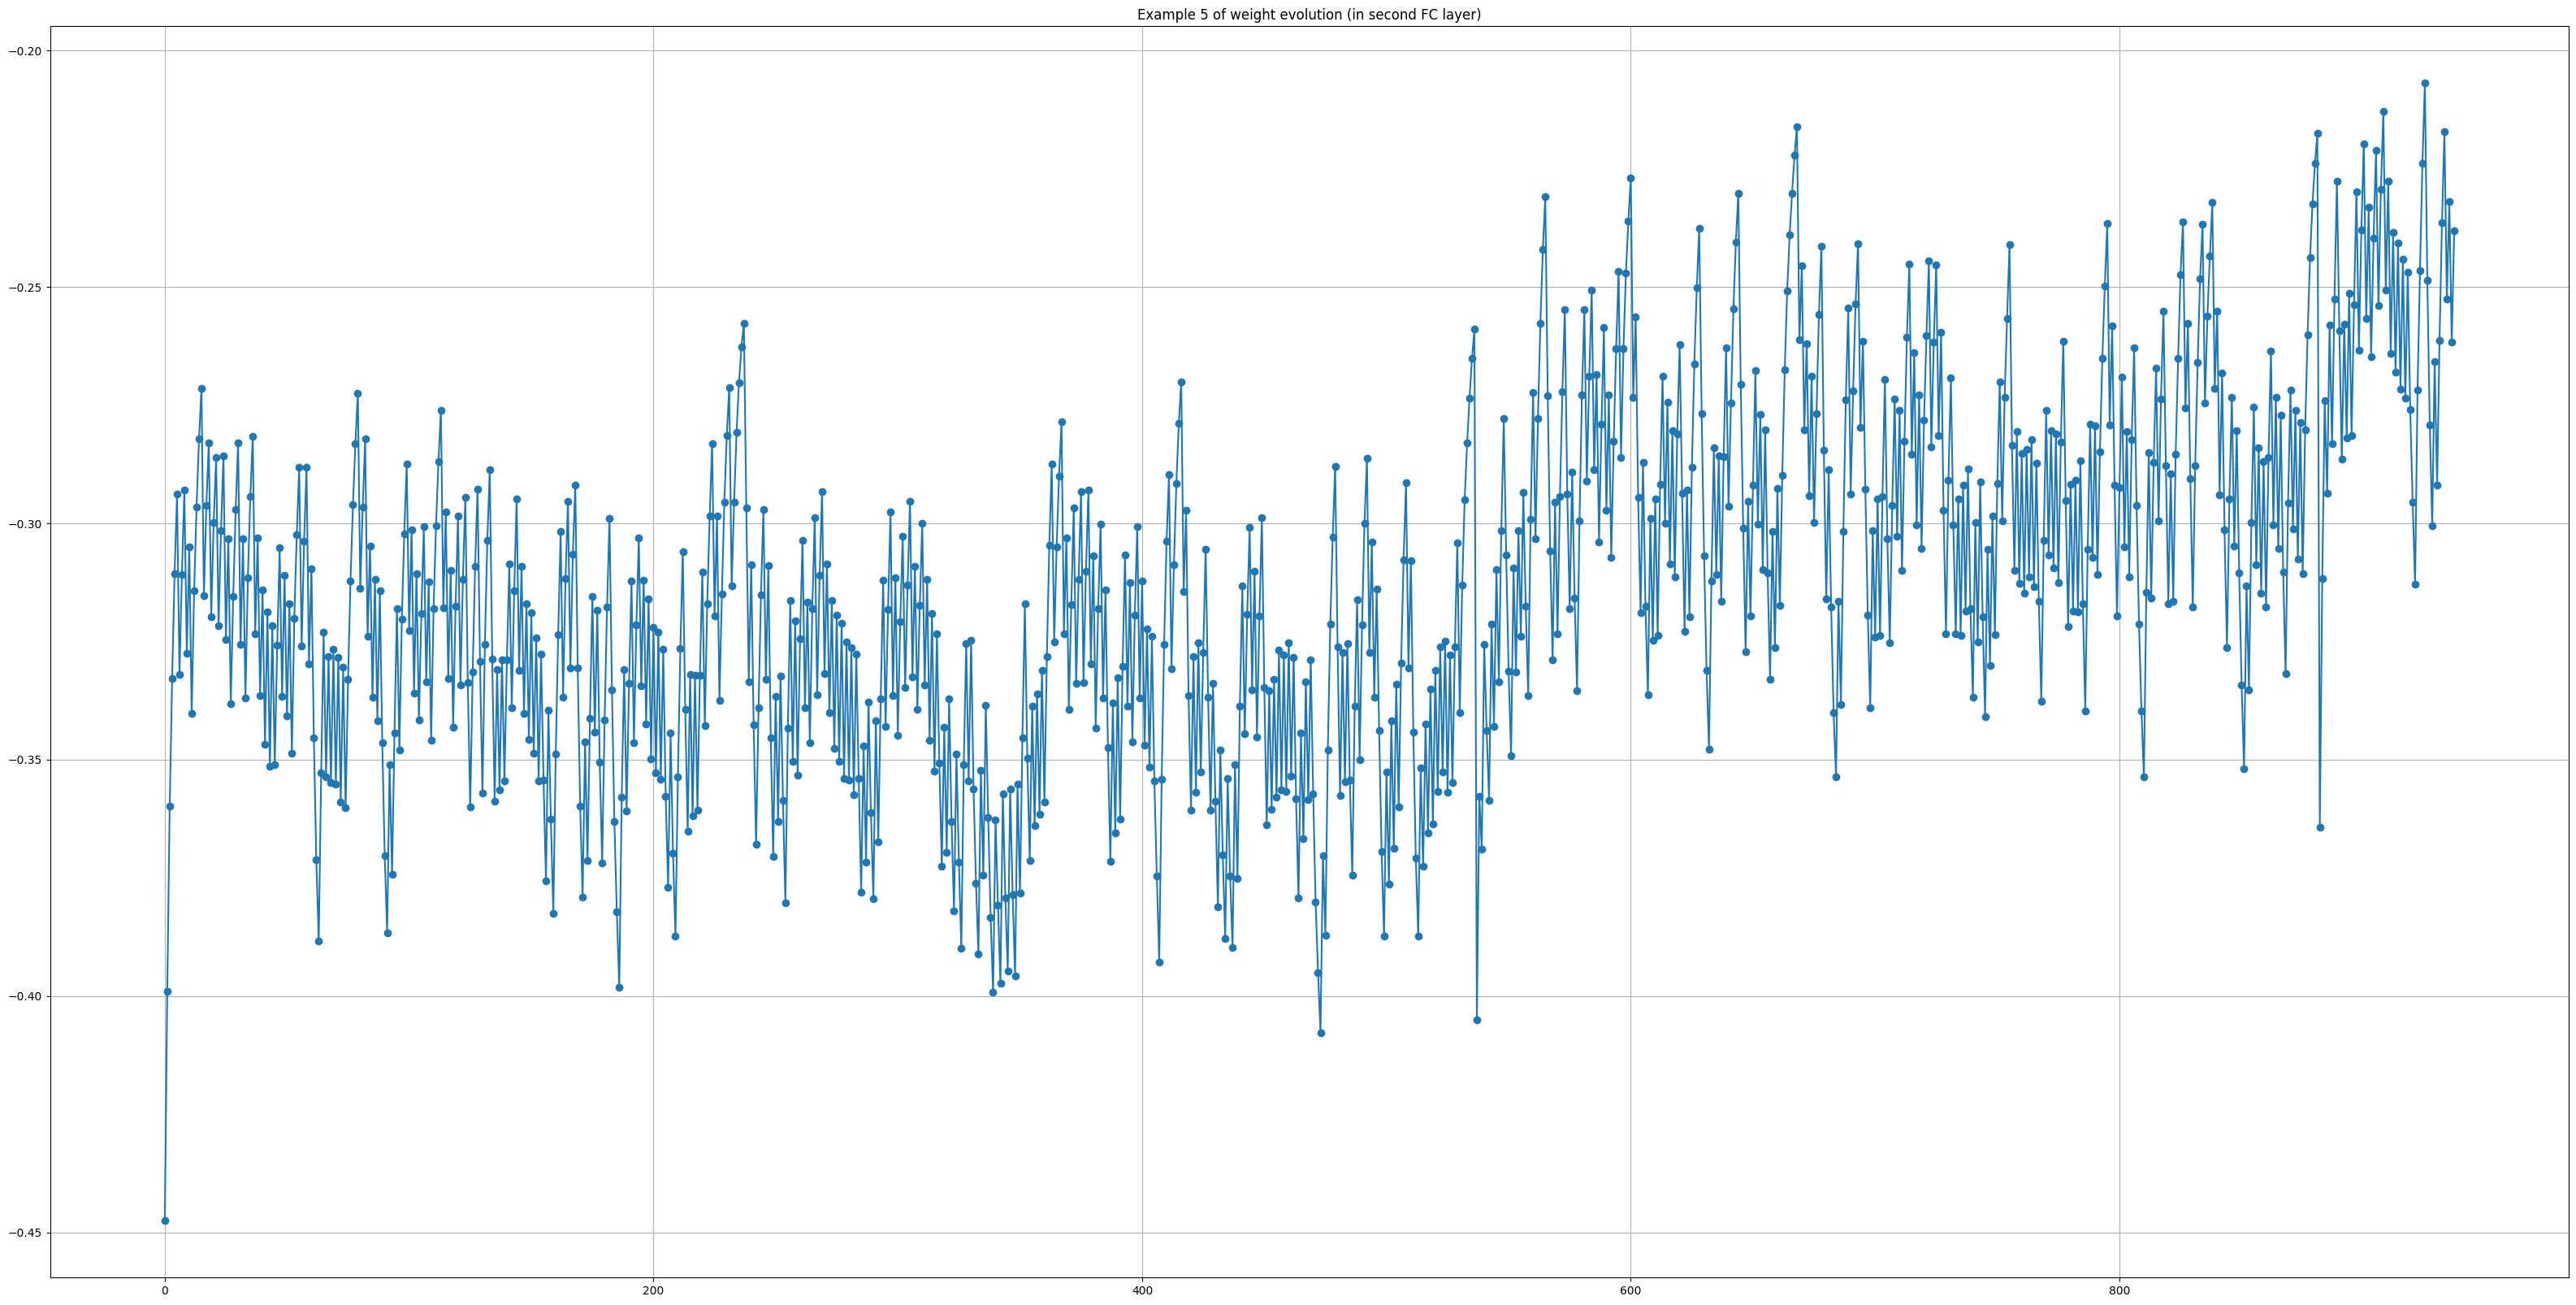

In [28]:
plt.figure(figsize=(40, 20))
plt.grid()
plt.title("Example 5 of weight evolution (in second FC layer)")
plt.plot(weight_evolution_list_5, marker='o')
plt.show()